# Inference

You **must** run `data_and_training.ipynb` before running this notebook. This notebook no longer includes ARIMA because it (and its corresponding `src/predict.py`) is used to infer with the trained `DeTention` model, not ARIMA.

**Note:** The notebooks save and load models from the `notebooks/models/` directory, which is a simple way to prevent models trained here from overwriting models trained via scripts. This wouldn’t be a problem if the results were reproducible, but since we fetch the latest data, they are not.

I will skip blah-blah and start with imports and logger config:

In [67]:
!pip install matplotlib
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d/%m/%Y %H:%M:%S')
logger = logging.getLogger("BackToThePredictLogger (Predict)")

These are from `DeTention.py` and/or `data_and_training.ipynb`, but they need to be present here as well. Just ignore it; you are already familiar with these classes:

In [68]:
class RoPE(nn.Module):
    def __init__(self, dim: int, base: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.base = base
        inv_freq = 1.0 / (base ** (torch.arange(start=0, end=dim, step=2, dtype=torch.float32) / dim))
        self.register_buffer(name="inv_freq", tensor=inv_freq, persistent=True)

    def forward(self, x: torch.Tensor, seq_len: int) -> torch.Tensor:
        positions = torch.arange(0, seq_len, device=x.device, dtype=self.inv_freq.dtype)
        angles = positions[:, None] * self.inv_freq[None, :]
        sin, cos = torch.sin(angles), torch.cos(angles)
        sin = sin.unsqueeze(0)
        cos = cos.unsqueeze(0)
        x1 = x[..., : self.dim // 2]
        x2 = x[..., self.dim // 2:]
        rotated_x1 = x1 * cos - x2 * sin
        rotated_x2 = x1 * sin + x2 * cos
        return torch.cat([rotated_x1, rotated_x2], dim=-1)


class DeTentionBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, ff_hidden_size: int = 256, dropout: float = 0.2):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.ff_hidden_size = ff_hidden_size
        self.dropout = dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.rope = RoPE(dim=d_model, base=10000.0)
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(nn.Linear(d_model, ff_hidden_size), nn.GLU(dim=-1), nn.Dropout(dropout), nn.Linear(ff_hidden_size // 2, d_model))
        self.dropout_layer = nn.Dropout(dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.norm1(x)
        q, k = self.rope(x, seq_len=x.shape[1]), self.rope(x, seq_len=x.shape[1])
        attn_output, _ = self.attention(query=q, key=k, value=x, need_weights=False)
        x = self.dropout_layer(attn_output) + residual
        residual = x
        x = self.ff(self.norm2(x))
        x = self.dropout_layer(x) + residual
        return x


class DeTention(nn.Module):
    def __init__(self, seq_len: int = 30, d_model: int = 64, n_heads: int = 4, n_layers: int = 2, ff_hidden_size: int = 256, dropout: float = 0.2, use_avg_pool: bool = True):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        self.use_avg_pool = use_avg_pool
        self.input_proj = nn.Linear(1, d_model)
        self.DeTention_blocks = nn.ModuleList([DeTentionBlock(d_model=d_model, n_heads=n_heads, ff_hidden_size=ff_hidden_size, dropout=dropout) for i in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.output_head = nn.Linear(d_model, 1)
        if use_avg_pool:
            self.pool = nn.AdaptiveAvgPool1d(output_size=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_proj(x)
        for block in self.DeTention_blocks:
            x = block(x)
        x = self.norm(x)
        x = self.pool(x.transpose(1, 2)).squeeze(-1) if self.use_avg_pool else x[:, -1, :]
        x = self.output_head(x)
        return x.squeeze(dim=-1)


def save_model(model: DeTention, path: str = "models/DeTention.pth") -> None:
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({ 'state_dict': model.state_dict(), 'config': { 'seq_len': model.seq_len, 'd_model': model.d_model, 'use_avg_pool': model.use_avg_pool } }, path)


def load_model(path: str = "models/DeTention.pth", **model_kwargs) -> DeTention:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")
    checkpoint = torch.load(path, map_location=torch.device('cpu'), weights_only=True)
    config = checkpoint.get('config', {})
    config.update(model_kwargs)
    model = DeTention(**config)
    model.load_state_dict(checkpoint['state_dict'])
    return model

Define a method to get the most recent data with dates:

In [69]:
def get_recent_data(ticker: str, period: str = "3y") -> tuple[np.ndarray, list]:
    data = yf.Ticker(ticker)
    df = data.history(period=period)
    df.drop(columns=["Dividends", "Stock Splits"], inplace=True, errors='ignore')
    close_prices = df['Close'].values.reshape(-1, 1)
    dates = df.index.tolist()
    return close_prices, dates

Test the model by predicting today's price and comparing it with the actual price:

In [70]:
def test_prediction(model: DeTention, scaler: MinMaxScaler, ticker: str = "PINS", L: int = 30, period: str = "3y"):
    logger.info("TESTING MODEL ON RECENT DATA")

    series, dates = get_recent_data(ticker, period=period)

    if len(series) < L + 1:
        raise ValueError(f"Not enough data points ({len(series)}) for lookback {L} + 1 for testing")

    # use the last L + 1 points: L for input, 1 for actual target
    test_window = series[-(L + 1):-1]  # last L days (excluding most recent)
    actual_price = series[-1, 0]  # most recent day (today's actual close)
    actual_date = dates[-1]

    test_scaled = scaler.transform(test_window)
    input_tensor = torch.tensor(test_scaled, dtype=torch.float32).unsqueeze(0)  # (1, L, 1)

    with torch.no_grad():
        scaled_pred = model(input_tensor).item()

    predicted_price = scaler.inverse_transform([[scaled_pred]])[0][0]
    error = abs(predicted_price - actual_price)
    error_pct = (error / actual_price) * 100

    logger.info(f"Date: {actual_date.strftime('%Y-%m-%d')}")
    logger.info(f"Actual closing price: ${actual_price:.2f}")
    logger.info(f"Predicted price: ${predicted_price:.2f}")
    logger.info(f"Absolute error: ${error:.2f}")
    logger.info(f"Percentage error: {error_pct:.2f}%")

    return {
        'date': actual_date,
        'actual': actual_price,
        'predicted': predicted_price,
        'error': error,
        'error_pct': error_pct
    }

Obviously, I also need a method to predict the price for the next day simply:

In [71]:
def predict_next_day(model: DeTention, scaler: MinMaxScaler, ticker: str = "PINS", L: int = 30, period: str = "3y"):
    logger.info("PREDICTING NEXT TRADING DAY")

    series, dates = get_recent_data(ticker, period=period)

    if len(series) < L:
        raise ValueError(f"Not enough data points ({len(series)}) for lookback {L}")

    # use the most recent L days
    recent_window = series[-L:]
    last_date = dates[-1]
    input_tensor = torch.tensor(scaler.transform(recent_window), dtype=torch.float32).unsqueeze(0)  # (1, L, 1)

    with torch.no_grad():
        scaled_pred = model(input_tensor).item()

    pred = scaler.inverse_transform([[scaled_pred]])[0][0]

    logger.info(f"Last trading day: {last_date.strftime('%Y-%m-%d')}")
    logger.info(f"Last closing price: ${series[-1, 0]:.2f}")
    logger.info(f"Predicted next-day closing price: ${pred:.2f}")

    return pred

and a method for visualization later on (I used Gemini 3 Pro to generate this method, I suck at visualization):

In [72]:
def visualize_recent_predictions(model: DeTention, scaler: MinMaxScaler, series: np.ndarray, dates: list, ticker: str = "PINS", L: int = 30, lookback_days: int = 30):
    logger.info("VISUALIZING RECENT PREDICTIONS OVER PAST %d DAYS", lookback_days)

    if len(series) < L + lookback_days:
        logger.warning("Not enough data for %d-day visualization with L=%d; skipping", lookback_days, L)
        return

    recent_series = series[-(L + lookback_days):]
    recent_dates = dates[-(lookback_days):]

    actual_prices = recent_series[-lookback_days:, 0]
    predicted_prices = []

    for i in range(lookback_days):
        window = recent_series[i:i + L]
        scaled_window = scaler.transform(window)
        input_tensor = torch.tensor(scaled_window, dtype=torch.float32).unsqueeze(0)  # (1, L, 1)
        with torch.no_grad():
            scaled_pred = model(input_tensor).item()
        pred = scaler.inverse_transform([[scaled_pred]])[0][0]
        predicted_prices.append(pred)

    # Plot
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(recent_dates, actual_prices, color='green', label='Actual Price', marker='o', linewidth=2)
    ax.plot(recent_dates, predicted_prices, color='purple', label='Predicted Price', marker='x', linewidth=2, linestyle='--')
    ax.set_title(f'{ticker} Stock Price: Actual vs Predicted (Last {lookback_days} Days)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price ($)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plot_path = f"models/{ticker}_prediction_plot.png"
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    logger.info("Prediction plot saved to %s", plot_path)

Hyperparameters:

In [73]:
model_path = "models/DeTention.pth"
scaler_path = "models/scaler.pkl"
ticker = "PINS"
L = 30
period = "3y"
test = True
predict = True

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found: {model_path}")

if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Scaler not found: {scaler_path}")

Time for inference!

22/12/2025 19:50:16 - BackToThePredictLogger (Predict) - INFO - Loading model from models/DeTention.pth
22/12/2025 19:50:16 - BackToThePredictLogger (Predict) - INFO - Loading scaler from models/scaler.pkl
22/12/2025 19:50:16 - BackToThePredictLogger (Predict) - INFO - TESTING MODEL ON RECENT DATA
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Date: 2025-12-22
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Actual closing price: $26.45
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Predicted price: $25.53
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Absolute error: $0.92
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Percentage error: 3.49%
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - TEST RESULTS FOR PINS
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Date: 2025-12-22
22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Actual Price: $26.455
22/12/2025 1

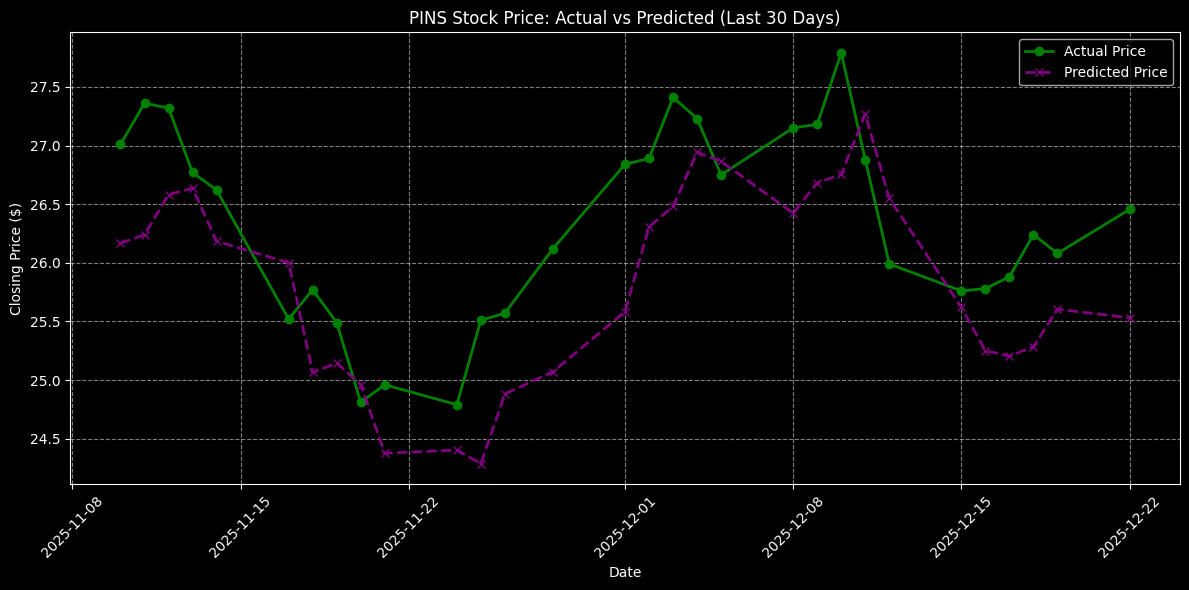

22/12/2025 19:50:17 - BackToThePredictLogger (Predict) - INFO - Prediction plot saved to models/PINS_prediction_plot.png


In [74]:
logger.info("Loading model from %s", model_path)
model = load_model(model_path)
model.eval()

logger.info("Loading scaler from %s", scaler_path)
scaler = joblib.load(scaler_path)

if test:
    test_results = test_prediction(model, scaler, ticker=ticker, L=L, period=period)
    logger.info("TEST RESULTS FOR %s", ticker)
    logger.info("Date: %s", test_results['date'].strftime('%Y-%m-%d'))
    logger.info("Actual Price: $%.3f", test_results['actual'])
    logger.info("Predicted Price: $%.3f", test_results['predicted'])
    logger.info("Error: $%.3f (%.2f%%)", test_results['error'], test_results['error_pct'])

if predict:
    next_price = predict_next_day(model, scaler, ticker=ticker, L=L, period=period)
    logger.info("NEXT-DAY PREDICTION FOR %s", ticker)
    logger.info("Predicted Closing Price: $%.3f", next_price)

    # fetch data once and reuse for visualization (from predict_next_day or test)
    series, dates = get_recent_data(ticker, period=period)
    visualize_recent_predictions(model, scaler, series, dates, ticker=ticker, L=L)

As the stock data gets updated each and every day, the output will not be the same (plus I did not make the result reproducible; for `DataLoader`, that's a lot of ugly work!), but here is an output from my run:

```bash
Loading model from models/DeTention.pth
Loading scaler from models/scaler.pkl
TESTING MODEL ON RECENT DATA
Date: 2025-12-19
Actual closing price: $26.08
Predicted price: $25.95
Absolute error: $0.13
Percentage error: 0.51%
TEST RESULTS FOR PINS
Date: 2025-12-19
Actual Price: $26.080
Predicted Price: $25.947
Error: $0.133 (0.51%)
PREDICTING NEXT TRADING DAY
Last trading day: 2025-12-19
Last closing price: $26.08
Predicted next-day closing price: $25.92
NEXT-DAY PREDICTION FOR PINS
Predicted Closing Price: $25.92
```

So the results look great from my side! Though the error might not be tolerable for trading firms, that's why they hire quants and why I am not one of them.